## In this notebook, we will train an Energy-Based Model (EBM) to debias the Adult dataset from UCI

The **UCI Adult dataset** contains **48,842 instances** with **14 demographic and employment-related features**,  
and a **binary income label** indicating whether an individual's annual income exceeds **$50K** or not.  
Our goal is to train an **Energy-Based Model (EBM)** that helps **mitigate bias** in income prediction.

### Dataset Setup and Bias Analysis

**Problem Statement**: The original Adult dataset from UCI exhibits significant gender bias, where the conditional probability of income given gender differs substantially from the marginal probability of income: **P(income|gender) ≠ P(income)**.

**Dataset Creation**:
- **Biased Dataset**: The full original dataset (43,844 samples) where gender and income are highly correlated
- **Debiased Dataset**: A carefully sampled subset (4,998 samples) where **P(income|gender) = P(income)**, effectively removing the gender-income correlation

**Objective**: Train an Energy-Based Model (EBM) to learn the debiased distribution from the small unbiased dataset and use it to generate new samples that maintain the debiased properties, thereby reducing the correlation between income and gender in synthetic data generation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# load the biased and debiased datasets
df_biased = pd.read_csv("biased_dataset.csv")
df_debiased = pd.read_csv("debiased_dataset.csv")

print(f"Biased dataset shape: {df_biased.shape}")
print(f"Debiased dataset shape: {df_debiased.shape}")
print(f"\nColumns: {df_biased.columns.tolist()}")
print(f"\nBiased dataset gender-income distribution:")
print(pd.crosstab(df_biased['sex'], df_biased['income'], normalize='index'))
print(f"\nDebiased dataset gender-income distribution:")
print(pd.crosstab(df_debiased['sex'], df_debiased['income'], normalize='index'))

Biased dataset shape: (43844, 15)
Debiased dataset shape: (4998, 15)

Columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

Biased dataset gender-income distribution:
income     <=50K      >50K
sex                       
Female  0.891994  0.108006
Male    0.696277  0.303723

Debiased dataset gender-income distribution:
income     <=50K      >50K
sex                       
Female  0.760704  0.239296
Male    0.760704  0.239296


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:0


## Step 1: Data Preprocessing
We need to encode categorical variables and normalize numerical features


In [4]:
# Define categorical and numerical columns
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 
                    'relationship', 'race', 'sex', 'native-country', 'income']
numerical_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
                  'capital-loss', 'hours-per-week']

# Encode categorical variables and normalize numerical features
def preprocess_data(df, fit=True, encoders=None, scaler=None):
    df_encoded = df.copy()
    
    if fit:
        encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
        
        scaler = StandardScaler()
        df_encoded[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    else:
        for col in categorical_cols:
            df_encoded[col] = encoders[col].transform(df[col].astype(str))
        df_encoded[numerical_cols] = scaler.transform(df[numerical_cols])
    
    return df_encoded, encoders, scaler

# Preprocess biased and debiased datasets
df_biased_encoded, encoders, scaler = preprocess_data(df_biased, fit=True)
df_debiased_encoded, _, _ = preprocess_data(df_debiased, fit=False, encoders=encoders, scaler=scaler)

print(f"Encoded biased dataset shape: {df_biased_encoded.shape}")
print(f"Encoded debiased dataset shape: {df_debiased_encoded.shape}")

# Get the number of categories for each categorical column
num_categories = {col: len(encoders[col].classes_) for col in categorical_cols}
print(f"\nNumber of categories per column: {num_categories}")


Encoded biased dataset shape: (43844, 15)
Encoded debiased dataset shape: (4998, 15)

Number of categories per column: {'workclass': 10, 'education': 16, 'marital-status': 7, 'occupation': 16, 'relationship': 6, 'race': 5, 'sex': 2, 'native-country': 43, 'income': 2}


## Step 2: Build Tabular VAE (TVAE)
TVAE handles mixed data types with separate decoders for categorical and numerical features


In [5]:
class TabularVAE(nn.Module):
    def __init__(self, num_numerical, num_categories_list, latent_dim=10, hidden_dim=128):
        super(TabularVAE, self).__init__()
        self.num_numerical = num_numerical
        self.num_categories_list = num_categories_list
        self.num_categorical = len(num_categories_list)
        self.latent_dim = latent_dim
        
        # Total input dimension (numerical + one-hot encoded categorical)
        total_cat_dim = sum(num_categories_list)
        input_dim = num_numerical + total_cat_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder for numerical features
        self.decoder_numerical = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, num_numerical),
        )
        
        # Decoder for categorical features (separate head for each categorical variable)
        self.decoder_categorical = nn.ModuleList([
            nn.Sequential(
                nn.Linear(latent_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, num_cat)
            ) for num_cat in num_categories_list
        ])
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        numerical_out = self.decoder_numerical(z)
        categorical_out = [decoder(z) for decoder in self.decoder_categorical]
        return numerical_out, categorical_out
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        numerical_out, categorical_out = self.decode(z)
        return numerical_out, categorical_out, mu, logvar
    
    def prepare_input(self, numerical_data, categorical_data):
        """Convert numerical + categorical data to one-hot encoded input"""
        batch_size = numerical_data.shape[0]
        
        # One-hot encode categorical features
        cat_one_hot = []
        for i, num_cat in enumerate(self.num_categories_list):
            one_hot = torch.zeros(batch_size, num_cat, device=numerical_data.device)
            one_hot.scatter_(1, categorical_data[:, i:i+1].long(), 1)
            cat_one_hot.append(one_hot)
        
        cat_one_hot = torch.cat(cat_one_hot, dim=1)
        return torch.cat([numerical_data, cat_one_hot], dim=1)

# Initialize TVAE
num_categories_list = [num_categories[col] for col in categorical_cols]
latent_dim = 10
tvae = TabularVAE(
    num_numerical=len(numerical_cols), 
    num_categories_list=num_categories_list,
    latent_dim=latent_dim,
    hidden_dim=128
).to(device)

print(f"TVAE initialized with {latent_dim} latent dimensions")
print(f"Total parameters: {sum(p.numel() for p in tvae.parameters())}")


TVAE initialized with 10 latent dimensions
Total parameters: 127109


In [6]:
def tvae_loss(numerical_out, categorical_out, numerical_true, categorical_true, mu, logvar):
    """TVAE loss: MSE for numerical + CrossEntropy for categorical + KL divergence"""
    
    # Numerical reconstruction loss (MSE)
    numerical_loss = nn.functional.mse_loss(numerical_out, numerical_true, reduction='sum')
    
    # Categorical reconstruction loss (CrossEntropy for each categorical variable)
    categorical_loss = 0
    for i, cat_out in enumerate(categorical_out):
        categorical_loss += nn.functional.cross_entropy(
            cat_out, categorical_true[:, i].long(), reduction='sum'
        )
    
    # KL divergence
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return numerical_loss + categorical_loss + kld, numerical_loss, categorical_loss, kld


## Step 3: Train TVAE on Biased Dataset


In [7]:
# Prepare data for training
numerical_biased = torch.tensor(df_biased_encoded[numerical_cols].values, dtype=torch.float32)
categorical_biased = torch.tensor(df_biased_encoded[categorical_cols].values, dtype=torch.float32)

# Create dataset and dataloader
batch_size = 256
dataset_biased = TensorDataset(numerical_biased, categorical_biased)
train_len = int(0.8 * len(dataset_biased))
val_len = len(dataset_biased) - train_len
train_set, val_set = random_split(dataset_biased, [train_len, val_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Train TVAE
optimizer = optim.Adam(tvae.parameters(), lr=1e-3)
best_val_loss = float('inf')
patience = 10
patience_counter = 0
epochs = 100

print("Training TVAE on biased dataset...")
epoch_iter = tqdm(range(epochs), desc="Training TVAE")
for epoch in epoch_iter:
    tvae.train()
    train_loss = 0
    for num_batch, cat_batch in train_loader:
        num_batch = num_batch.to(device)
        cat_batch = cat_batch.to(device)
        
        # Prepare input
        x = tvae.prepare_input(num_batch, cat_batch)
        
        # Forward pass
        numerical_out, categorical_out, mu, logvar = tvae(x)
        
        # Compute loss
        loss, num_loss, cat_loss, kld = tvae_loss(
            numerical_out, categorical_out, num_batch, cat_batch, mu, logvar
        )
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    tvae.eval()
    val_loss = 0
    with torch.no_grad():
        for num_batch, cat_batch in val_loader:
            num_batch = num_batch.to(device)
            cat_batch = cat_batch.to(device)
            x = tvae.prepare_input(num_batch, cat_batch)
            numerical_out, categorical_out, mu, logvar = tvae(x)
            loss, _, _, _ = tvae_loss(numerical_out, categorical_out, num_batch, cat_batch, mu, logvar)
            val_loss += loss.item()
    
    epoch_iter.set_postfix(
        train_loss=train_loss / len(train_loader.dataset),
        val_loss=val_loss / len(val_loader.dataset)
    )
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = tvae.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

tvae.load_state_dict(best_state)
print("TVAE training complete!")


Training TVAE on biased dataset...


Training TVAE: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s, train_loss=11.6, val_loss=11.7]

TVAE training complete!


## Step 4: Visualize Latent Space


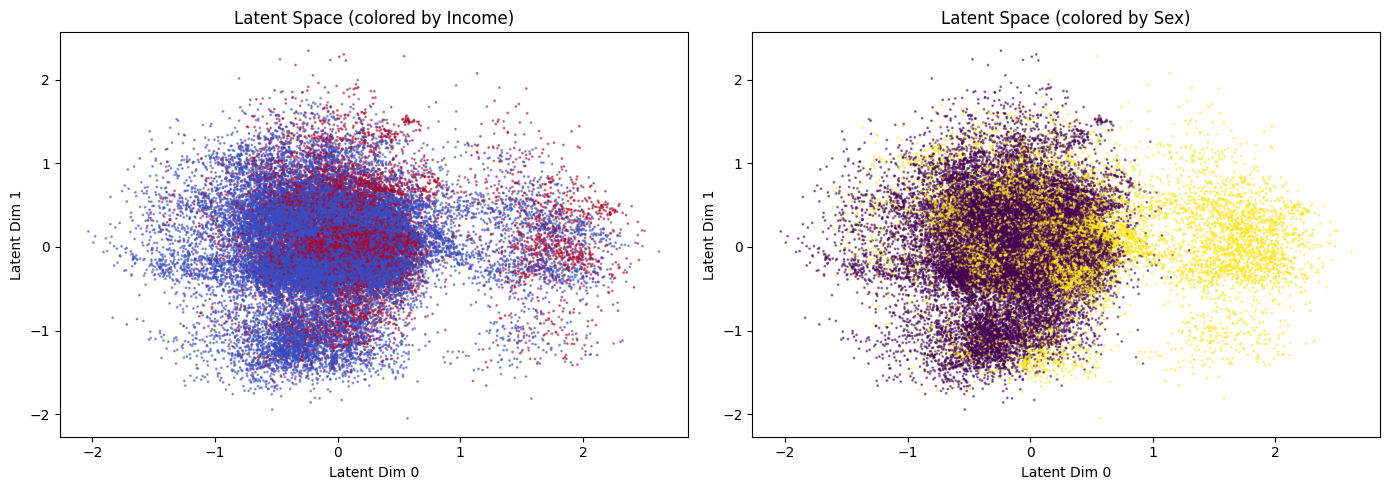

In [8]:
# Encode biased dataset to latent space
tvae.eval()
with torch.no_grad():
    x_biased = tvae.prepare_input(numerical_biased.to(device), categorical_biased.to(device))
    mu_biased, _ = tvae.encode(x_biased)
    latent_biased = mu_biased.cpu().numpy()

# Visualize first 2 dimensions colored by income and sex
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Color by income
income_labels = df_biased['income'].values
axes[0].scatter(latent_biased[:, 0], latent_biased[:, 1], 
                c=[0 if inc == '<=50K' else 1 for inc in income_labels], 
                s=1, alpha=0.5, cmap='coolwarm')
axes[0].set_xlabel('Latent Dim 0')
axes[0].set_ylabel('Latent Dim 1')
axes[0].set_title('Latent Space (colored by Income)')

# Color by sex
sex_labels = df_biased['sex'].values
axes[1].scatter(latent_biased[:, 0], latent_biased[:, 1], 
                c=[0 if sex == 'Male' else 1 for sex in sex_labels], 
                s=1, alpha=0.5, cmap='viridis')
axes[1].set_xlabel('Latent Dim 0')
axes[1].set_ylabel('Latent Dim 1')
axes[1].set_title('Latent Space (colored by Sex)')

plt.tight_layout()
plt.show()


## Step 5: Build and Train EBM on Latent Space
We train the EBM on the debiased dataset's latent representations


In [9]:
class EBM(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super(EBM, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
        )
    
    def forward(self, x):
        return self.net(x).squeeze()
    
    def energy(self, x):
        return self.forward(x)

# Initialize EBM
ebm = EBM(input_dim=latent_dim, hidden_dim=256).to(device)
print(f"EBM initialized with {sum(p.numel() for p in ebm.parameters())} parameters")


EBM initialized with 35841 parameters


In [10]:
# Prepare debiased data for EBM training
numerical_debiased = torch.tensor(df_debiased_encoded[numerical_cols].values, dtype=torch.float32)
categorical_debiased = torch.tensor(df_debiased_encoded[categorical_cols].values, dtype=torch.float32)

# Encode debiased dataset to latent space
tvae.eval()
with torch.no_grad():
    x_debiased = tvae.prepare_input(numerical_debiased.to(device), categorical_debiased.to(device))
    mu_debiased, _ = tvae.encode(x_debiased)
    latent_debiased = mu_debiased.cpu()

# Create dataloader for EBM training
dataset_ebm = TensorDataset(latent_debiased)
train_len_ebm = int(0.8 * len(dataset_ebm))
val_len_ebm = len(dataset_ebm) - train_len_ebm
train_set_ebm, val_set_ebm = random_split(dataset_ebm, [train_len_ebm, val_len_ebm])

train_loader_ebm = DataLoader(train_set_ebm, batch_size=128, shuffle=True)
val_loader_ebm = DataLoader(val_set_ebm, batch_size=128, shuffle=False)

# Train EBM
ebm_optimizer = optim.Adam(ebm.parameters(), lr=1e-3)
ebm_epochs = 50

print("Training EBM on debiased latent representations...")
pbar = tqdm(range(ebm_epochs), desc="EBM Training")
for epoch in pbar:
    ebm.train()
    for batch in train_loader_ebm:
        latents = batch[0].to(device)
        
        # Positive energy (from debiased data)
        pos_energy = ebm.energy(latents)
        
        # Negative samples from standard normal
        neg_samples = torch.randn_like(latents).to(device)
        neg_energy = ebm.energy(neg_samples)
        
        # Contrastive loss (minimize energy for positive, maximize for negative)
        contrastive_loss = pos_energy.mean() - neg_energy.mean()
        
        # Energy norm regularization
        reg_loss = (pos_energy**2).mean() + (neg_energy**2).mean()
        
        # Gradient regularization
        interp = torch.rand(latents.size(0), 1, device=device)
        x_interp = (interp * latents + (1 - interp) * neg_samples).requires_grad_(True)
        energy_interp = ebm.energy(x_interp).mean()
        grad_interp = torch.autograd.grad(energy_interp, x_interp, create_graph=True)[0]
        grad_reg_loss = grad_interp.norm(2, dim=1).mean()
        
        # Total loss
        total_loss = contrastive_loss + 0.1 * reg_loss + 0.1 * grad_reg_loss
        
        ebm_optimizer.zero_grad()
        total_loss.backward()
        ebm_optimizer.step()
    
    pbar.set_postfix(
        loss=total_loss.item(),
        pos_energy=pos_energy.mean().item(),
        neg_energy=neg_energy.mean().item()
    )

print("EBM training complete!")


Training EBM on debiased latent representations...


EBM Training: 100%|██████████| 50/50 [00:03<00:00, 13.31it/s, loss=-4.87, neg_energy=4.91, pos_energy=-5.07] 

EBM training complete!


## Step 6: Sample from TVAE without EBM (Baseline)


In [11]:
def decode_samples(tvae, latent_samples, encoders, scaler):
    """Decode latent samples back to tabular data"""
    tvae.eval()
    with torch.no_grad():
        numerical_out, categorical_out = tvae.decode(latent_samples.to(device))
        
        # Get predictions for categorical variables
        categorical_pred = []
        for cat_out in categorical_out:
            categorical_pred.append(cat_out.argmax(dim=1).cpu().numpy())
        categorical_pred = np.stack(categorical_pred, axis=1)
        
        # Denormalize numerical features
        numerical_pred = scaler.inverse_transform(numerical_out.cpu().numpy())
        
    # Create DataFrame
    df_generated = pd.DataFrame(numerical_pred, columns=numerical_cols)
    for i, col in enumerate(categorical_cols):
        df_generated[col] = encoders[col].inverse_transform(categorical_pred[:, i])
    
    return df_generated

# Sample from standard normal prior (without EBM)
n_samples = 5000
latent_samples_baseline = torch.randn(n_samples, latent_dim)
df_generated_baseline = decode_samples(tvae, latent_samples_baseline, encoders, scaler)

print("Baseline samples (without EBM):")
print(df_generated_baseline.head())
print(f"\nGender-Income distribution (Baseline):")
print(pd.crosstab(df_generated_baseline['sex'], df_generated_baseline['income'], normalize='index'))


Baseline samples (without EBM):
         age         fnlwgt  education-num  capital-gain  capital-loss  \
0  43.838848  176009.281250       6.367264    456.554749     -0.153605   
1  26.677694  223905.578125       2.587425     43.352055    -15.244196   
2  30.174995  115894.476562       9.545161    273.025146     -3.706545   
3  28.907658  150957.921875       9.473866    124.074524     -0.310946   
4  44.217609  188561.906250      15.430367   1705.334351     -2.905825   

   hours-per-week     workclass     education      marital-status  \
0       41.761124       Private          11th  Married-civ-spouse   
1       65.962143       Private       5th-6th       Never-married   
2       37.990406       Private  Some-college       Never-married   
3       40.585911       Private       HS-grad  Married-civ-spouse   
4       55.454998  Self-emp-inc   Prof-school  Married-civ-spouse   

          occupation   relationship   race     sex native-country income  
0       Craft-repair        Husba

## Step 7: Sample from TVAE with EBM Tilting
We use energy-weighted sampling to select latents with lower energy (more aligned with debiased distribution)


In [12]:
# Energy-weighted sampling from the standard normal prior
n_prior = 100000  # Generate large pool of candidates
ebm.eval()

with torch.no_grad():
    prior_samples = torch.randn(n_prior, latent_dim).to(device)
    energies = ebm.energy(prior_samples)  # Shape (n_prior,)
    
    # Boltzmann weights (lower energy = higher weight)
    weights = torch.softmax(-energies, dim=0)
    
    # Sample indices according to weights
    index_samples = torch.distributions.Categorical(weights).sample((n_samples,))
    latent_samples_ebm = prior_samples[index_samples].cpu()

# Decode EBM-tilted samples
df_generated_ebm = decode_samples(tvae, latent_samples_ebm, encoders, scaler)

print("EBM-tilted samples:")
print(df_generated_ebm.head())
print(f"\nGender-Income distribution (EBM-tilted):")
print(pd.crosstab(df_generated_ebm['sex'], df_generated_ebm['income'], normalize='index'))


EBM-tilted samples:
         age         fnlwgt  education-num  capital-gain  capital-loss  \
0  45.889477  180801.921875      11.087349   1488.453003     -2.169634   
1  38.866451  124851.562500      12.784703    356.139648     -2.022700   
2  31.141785  254067.031250       9.402332    146.045532     -1.265688   
3  54.339863  130255.992188       5.768675    448.340515     -4.954737   
4  51.780754  235170.000000       8.643537   -607.117432    344.657562   

   hours-per-week         workclass     education      marital-status  \
0       44.809296           Private  Some-college  Married-civ-spouse   
1       41.497356  Self-emp-not-inc     Bachelors  Married-civ-spouse   
2       40.427952           Private       HS-grad       Never-married   
3       44.467361           Private          10th  Married-civ-spouse   
4       39.115231               nan       HS-grad            Divorced   

         occupation   relationship   race     sex native-country income  
0   Exec-managerial   

## Step 7b: Sample from TVAE using SGLD (Stochastic Gradient Langevin Dynamics)
SGLD is another sampling method that iteratively refines samples by following the gradient of the energy landscape


In [13]:
def sgld_step(ebm, x, step_size=0.01, noise_std=0.1):
    """Perform one step of Stochastic Gradient Langevin Dynamics"""
    x.requires_grad_(True)
    
    # Compute the negative energy (we want to maximize this = minimize energy)
    # Also add log probability of the prior N(0,1) to keep samples reasonable
    energy = -ebm.energy(x) + torch.distributions.Normal(0, 1).log_prob(x).sum(dim=1)
    
    # Compute gradient
    grad = torch.autograd.grad(energy.sum(), x)[0]
    
    # SGLD update: move in gradient direction + add noise
    noise = torch.randn_like(x) * noise_std
    x_new = x + step_size * grad + noise
    
    return x_new.detach()

def sample_from_ebm_sgld(ebm, initial_samples, num_steps=1000, step_size=0.01, noise_std=0.01):
    """Sample from EBM using SGLD"""
    samples = initial_samples.clone().detach()
    paths = [samples.clone().detach()]
    
    for i in range(num_steps):
        samples = sgld_step(ebm, samples, step_size, noise_std)
        paths.append(samples.clone().detach())
    
    return paths

# Initialize samples from standard normal and run SGLD
print("Running SGLD sampling...")
initial_samples = torch.randn(n_samples, latent_dim).to(device)
sgld_paths = sample_from_ebm_sgld(
    ebm, 
    initial_samples, 
    num_steps=1000, 
    step_size=0.03, 
    noise_std=0.10
)

# Use the final samples
latent_samples_sgld = sgld_paths[-1].cpu()
print(f"SGLD completed with {len(sgld_paths)} steps")

# Decode SGLD samples
df_generated_sgld = decode_samples(tvae, latent_samples_sgld, encoders, scaler)

print("\nSGLD samples:")
print(df_generated_sgld.head())
print(f"\nGender-Income distribution (SGLD):")
print(pd.crosstab(df_generated_sgld['sex'], df_generated_sgld['income'], normalize='index'))


Running SGLD sampling...
SGLD completed with 1001 steps

SGLD samples:
         age         fnlwgt  education-num  capital-gain  capital-loss  \
0  37.533066  156217.000000      10.540505    412.416077     -1.420008   
1  38.897865  153131.015625      10.852838    410.708374     -0.438791   
2  31.078745  168894.515625      10.881227    202.756104     -2.654078   
3  40.545567  146005.062500       9.049028    196.501648     -1.110079   
4  38.553802  153470.781250       9.254410    232.232544     -2.235529   

   hours-per-week workclass     education      marital-status  \
0       47.965221   Private  Some-college       Never-married   
1       43.724621   Private  Some-college  Married-civ-spouse   
2       41.539383   Private  Some-college  Married-civ-spouse   
3       44.111485   Private       HS-grad            Divorced   
4       39.955254   Private       HS-grad       Never-married   

        occupation   relationship   race     sex native-country income  
0  Exec-managerial  

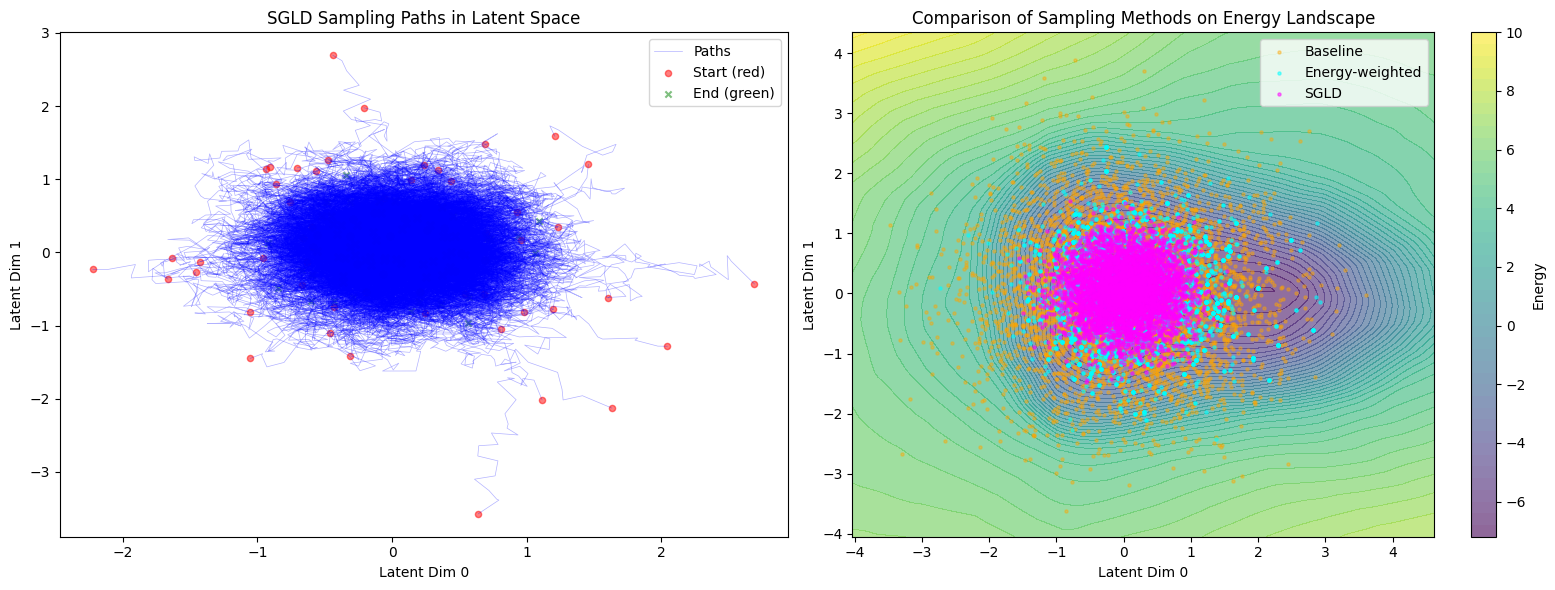

In [14]:
# Visualize SGLD paths in latent space
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: SGLD paths (show trajectories for first 64 samples)
axes[0].set_title('SGLD Sampling Paths in Latent Space')
for i in range(min(64, n_samples)):
    path = torch.stack([p[i] for p in sgld_paths])
    # convert path to numpy
    path = path.cpu().numpy()
    axes[0].plot(path[:, 0], path[:, 1], alpha=0.3, linewidth=0.5, color='blue')
    axes[0].scatter(path[0, 0], path[0, 1], c='red', s=20, alpha=0.5, marker='o')  # Start
    axes[0].scatter(path[-1, 0], path[-1, 1], c='green', s=20, alpha=0.5, marker='x')  # End

axes[0].set_xlabel('Latent Dim 0')
axes[0].set_ylabel('Latent Dim 1')
axes[0].legend(['Paths', 'Start (red)', 'End (green)'], loc='upper right')

# Plot 2: Energy landscape with all three sampling methods
# Recompute energy grid for visualization
grid_res = 200
x_min, x_max = latent_biased[:, 0].min() - 2, latent_biased[:, 0].max() + 2
y_min, y_max = latent_biased[:, 1].min() - 2, latent_biased[:, 1].max() + 2

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, grid_res),
    np.linspace(y_min, y_max, grid_res)
)

grid_points = np.zeros((grid_res * grid_res, latent_dim))
grid_points[:, 0] = xx.flatten()
grid_points[:, 1] = yy.flatten()

ebm.eval()
with torch.no_grad():
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)
    energies_grid = ebm.energy(grid_tensor).cpu().numpy().reshape(grid_res, grid_res)

im = axes[1].contourf(xx, yy, energies_grid, levels=50, cmap='viridis', alpha=0.6)
axes[1].scatter(latent_samples_baseline[:, 0], latent_samples_baseline[:, 1], 
                c='orange', s=5, alpha=0.4, label='Baseline')
axes[1].scatter(latent_samples_ebm[:, 0], latent_samples_ebm[:, 1], 
                c='cyan', s=5, alpha=0.5, label='Energy-weighted')
axes[1].scatter(latent_samples_sgld[:, 0], latent_samples_sgld[:, 1], 
                c='magenta', s=5, alpha=0.5, label='SGLD')
axes[1].set_xlabel('Latent Dim 0')
axes[1].set_ylabel('Latent Dim 1')
axes[1].set_title('Comparison of Sampling Methods on Energy Landscape')
axes[1].legend()
plt.colorbar(im, ax=axes[1], label='Energy')

plt.tight_layout()
plt.show()


## Step 8: Compare Results
We compare the gender-income correlation across different datasets


In [15]:
# Calculate correlation between gender and income for different datasets
def calculate_gender_income_correlation(df):
    """Calculate correlation between gender (Male=1, Female=0) and income (>50K=1, <=50K=0)"""
    gender_numeric = (df['sex'] == 'Male').astype(int)
    income_numeric = (df['income'] == '>50K').astype(int)
    correlation = np.corrcoef(gender_numeric, income_numeric)[0, 1]
    return correlation

# Calculate correlations
corr_biased = calculate_gender_income_correlation(df_biased)
corr_debiased = calculate_gender_income_correlation(df_debiased)
corr_baseline = calculate_gender_income_correlation(df_generated_baseline)
corr_ebm = calculate_gender_income_correlation(df_generated_ebm)
corr_sgld = calculate_gender_income_correlation(df_generated_sgld)

print("=" * 70)
print("CORRELATION BETWEEN GENDER AND INCOME:")
print("=" * 70)
print(f"Biased Dataset:              {corr_biased:.4f}")
print(f"Debiased Dataset:            {corr_debiased:.4f}")
print(f"Generated (Baseline):        {corr_baseline:.4f}")
print(f"Generated (Energy-weighted): {corr_ebm:.4f}")
print(f"Generated (SGLD):            {corr_sgld:.4f}")
print("=" * 70)
print(f"\nReduction in correlation:")
print(f"  Baseline → Energy-weighted: {abs(corr_baseline - corr_ebm):.4f} ({(abs(corr_baseline) - abs(corr_ebm)) / abs(corr_baseline) * 100:.2f}% improvement)")
print(f"  Baseline → SGLD:            {abs(corr_baseline - corr_sgld):.4f} ({(abs(corr_baseline) - abs(corr_sgld)) / abs(corr_baseline) * 100:.2f}% improvement)")


CORRELATION BETWEEN GENDER AND INCOME:
Biased Dataset:              0.2162
Debiased Dataset:            -0.0000
Generated (Baseline):        0.2186
Generated (Energy-weighted): 0.1061
Generated (SGLD):            0.0324

Reduction in correlation:
  Baseline → Energy-weighted: 0.1125 (51.46% improvement)
  Baseline → SGLD:            0.1862 (85.17% improvement)


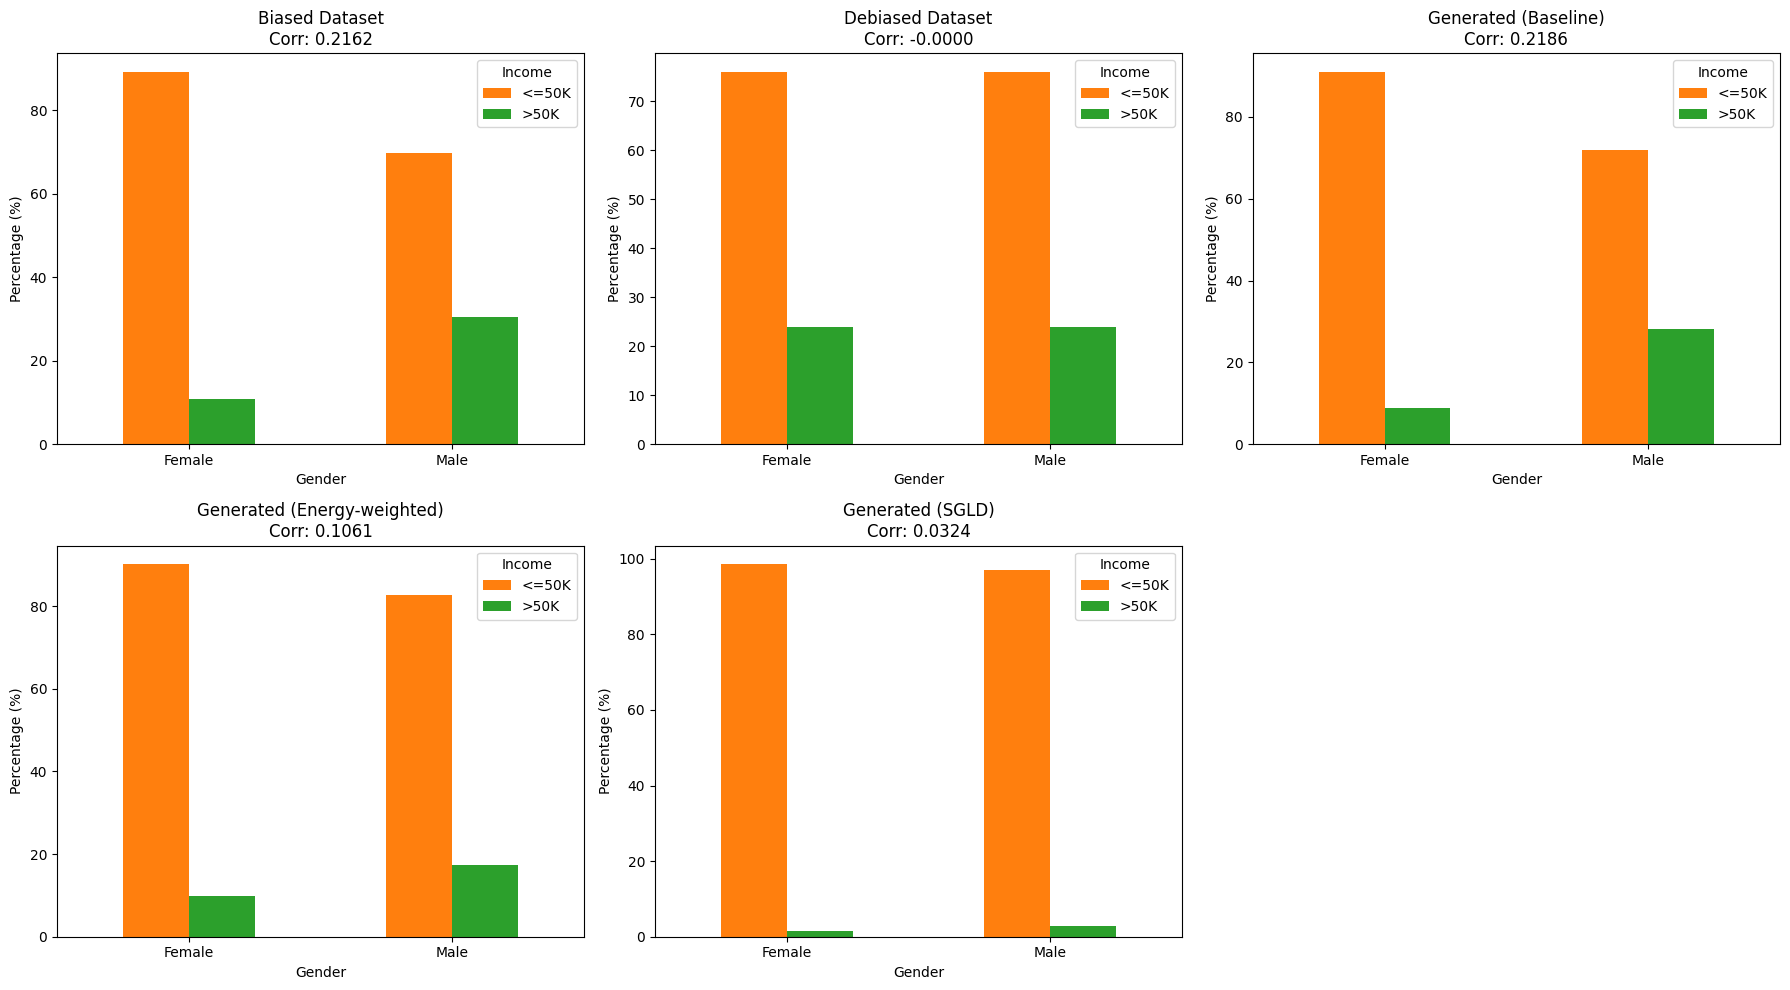

In [16]:
# Visualize gender-income distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

datasets = [
    (df_biased, "Biased Dataset", axes[0]),
    (df_debiased, "Debiased Dataset", axes[1]),
    (df_generated_baseline, "Generated (Baseline)", axes[2]),
    (df_generated_ebm, "Generated (Energy-weighted)", axes[3]),
    (df_generated_sgld, "Generated (SGLD)", axes[4])
]

for df, title, ax in datasets:
    crosstab = pd.crosstab(df['sex'], df['income'], normalize='index') * 100
    crosstab.plot(kind='bar', ax=ax, color=['#ff7f0e', '#2ca02c'])
    ax.set_title(f"{title}\nCorr: {calculate_gender_income_correlation(df):.4f}")
    ax.set_xlabel('Gender')
    ax.set_ylabel('Percentage (%)')
    ax.legend(title='Income', loc='upper right')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Hide the last empty subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


## Step 9: Visualize Energy Landscape in Latent Space


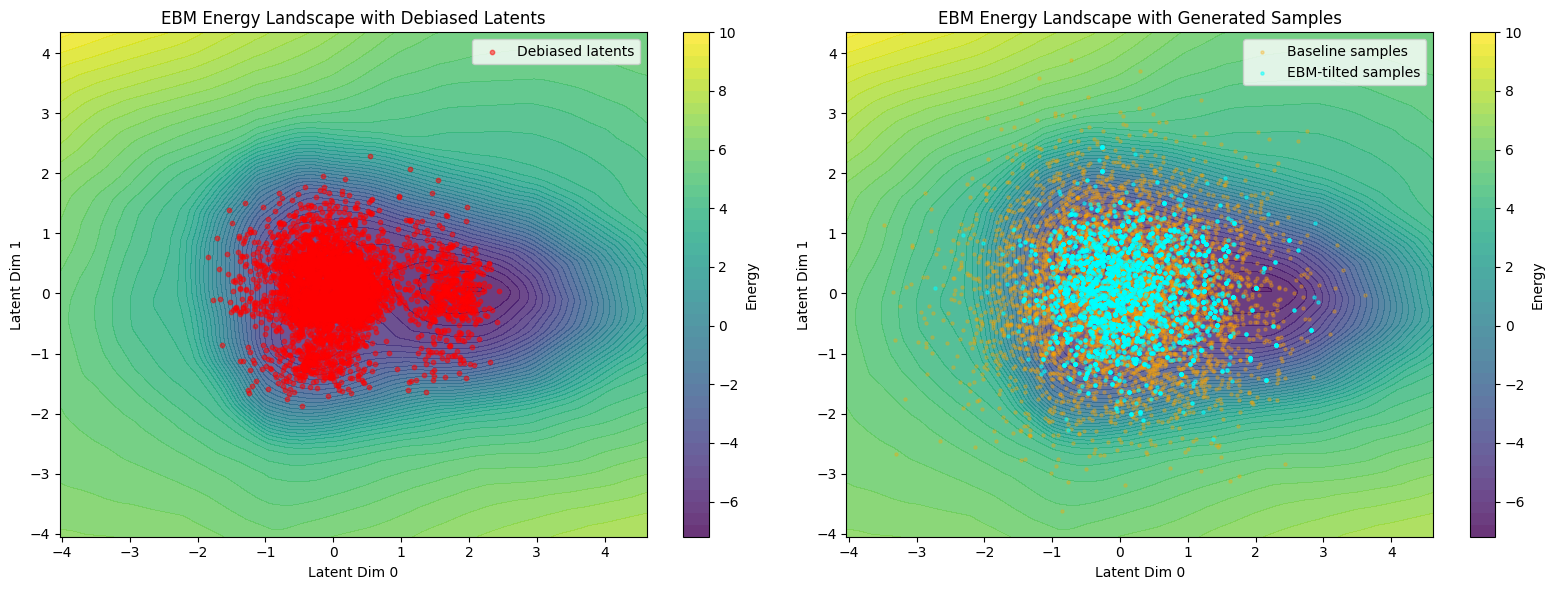

In [17]:
# Visualize energy landscape for first 2 latent dimensions
grid_res = 200
x_min, x_max = latent_biased[:, 0].min() - 2, latent_biased[:, 0].max() + 2
y_min, y_max = latent_biased[:, 1].min() - 2, latent_biased[:, 1].max() + 2

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, grid_res),
    np.linspace(y_min, y_max, grid_res)
)

# Create grid points (fix other dimensions to 0)
grid_points = np.zeros((grid_res * grid_res, latent_dim))
grid_points[:, 0] = xx.flatten()
grid_points[:, 1] = yy.flatten()

# Compute energy on grid
ebm.eval()
with torch.no_grad():
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)
    energies_grid = ebm.energy(grid_tensor).cpu().numpy().reshape(grid_res, grid_res)

# Plot energy landscape
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Energy landscape with debiased latents
im1 = axes[0].contourf(xx, yy, energies_grid, levels=50, cmap='viridis', alpha=0.8)
axes[0].scatter(latent_debiased[:, 0], latent_debiased[:, 1], 
                c='red', s=10, alpha=0.5, label='Debiased latents')
axes[0].set_xlabel('Latent Dim 0')
axes[0].set_ylabel('Latent Dim 1')
axes[0].set_title('EBM Energy Landscape with Debiased Latents')
axes[0].legend()
plt.colorbar(im1, ax=axes[0], label='Energy')

# Plot 2: Energy landscape with baseline vs EBM samples
im2 = axes[1].contourf(xx, yy, energies_grid, levels=50, cmap='viridis', alpha=0.8)
axes[1].scatter(latent_samples_baseline[:, 0], latent_samples_baseline[:, 1], 
                c='orange', s=5, alpha=0.3, label='Baseline samples')
axes[1].scatter(latent_samples_ebm[:, 0], latent_samples_ebm[:, 1], 
                c='cyan', s=5, alpha=0.5, label='EBM-tilted samples')
axes[1].set_xlabel('Latent Dim 0')
axes[1].set_ylabel('Latent Dim 1')
axes[1].set_title('EBM Energy Landscape with Generated Samples')
axes[1].legend()
plt.colorbar(im2, ax=axes[1], label='Energy')

plt.tight_layout()
plt.show()
